In [1]:
from transformers import AutoTokenizer,LlamaConfig,GenerationConfig
import torch
import os
import pandas as pd
import numpy as np
import pickle
import glob
import re
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import string
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools
import sys
sys.path.append('..')
from utils import get_segmentation_indices,segmentation_to_word_list
from utils import calculate_cross_entropy,normalize_entropy,model_to_path_dict
from split_event_by_timing import align_timing_with_text

In [2]:
stories = ['pieman','alternateithicatom','odetostepfather','souls','legacy','wheretheressmoke','adventuresinsayingyes','inamoment']
story_to_idx_mapping = {s:stories.index(s)+1 for s in stories}

In [3]:
story_to_idx_mapping

{'pieman': 1,
 'alternateithicatom': 2,
 'odetostepfather': 3,
 'souls': 4,
 'legacy': 5,
 'wheretheressmoke': 6,
 'adventuresinsayingyes': 7,
 'inamoment': 8}

In [4]:
factor = 1.5
save_dir = '../../generated'
model_name = 'Llama3-8b-instruct'
model_save_dir_name = model_to_path_dict[model_name]['save_dir_name']
model_initial_char = model_to_path_dict[model_name]['initial_char']
if model_name =='Llama3.2-3b-instruct_finetuned':
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
else:
    tokenizer = AutoTokenizer.from_pretrained(model_to_path_dict[model_name]['hf_name'])

moth_output_dir = os.path.join(save_dir,model_save_dir_name,'moth_stories_output')

/home/jianing/miniconda3/envs/speech/lib/python3.9/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
all_adjusted_split_df_timing = []
for story in stories:
    pairwise_event_save_dir_adjusted = os.path.join(save_dir,model_save_dir_name,'pairwise_event',story,'story_split_tokens_factor_%.1f_adjusted'%factor)
    adjusted_split_df_timing = pd.read_csv(os.path.join(pairwise_event_save_dir_adjusted,'story_split_by_token_df_adjusted.csv'))
    all_adjusted_split_df_timing.append(adjusted_split_df_timing)
all_adjusted_split_df_timing = pd.concat(all_adjusted_split_df_timing,ignore_index = True)
all_adjusted_split_df_timing['word_count'] = all_adjusted_split_df_timing['text'].str.split().str.len()
all_adjusted_split_df_timing['word_rate'] = all_adjusted_split_df_timing['word_count']/all_adjusted_split_df_timing['Duration']
all_adjusted_split_df_timing['conditioned_info_per_sec'] = all_adjusted_split_df_timing['H_event_conditioned']/all_adjusted_split_df_timing['Duration']

In [7]:
adjusted = True
if adjusted:
    uniform_encoding_df_name = 'uniform_encoding_df_even_split_by_tokens_factor_%.1f_adjusted.csv'%factor
    figure_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding','figures_even_split_by_tokens_factor_%.1f_adjusted'%factor)
    if not os.path.exists(figure_save_dir):
        os.makedirs(figure_save_dir)
else:
    uniform_encoding_df_name = 'uniform_encoding_df_even_split_by_tokens_factor_%.1f.csv'%factor
uniform_encoding_dfs = []
for story in stories:
    uniform_encoding_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding',story)
    # these csv are saved in uniform encoding hypothesis.ipynb
    story_uniform_encoding_df = pd.read_csv(os.path.join(uniform_encoding_save_dir,uniform_encoding_df_name))
    story_uniform_encoding_df['story']=story
    uniform_encoding_dfs.append(story_uniform_encoding_df)
all_uniform_encoding_df = pd.concat(uniform_encoding_dfs,ignore_index= True)
all_uniform_encoding_df=all_uniform_encoding_df.rename(columns={'H(event|prev events)': "H_event_conditioned", "H(event)": "H_event"})

In [8]:
all_uniform_encoding_df['chunk_type'] = ['Boundary' if i else 'Inner' for i in all_adjusted_split_df_timing['has_boundary']]
assert np.allclose(all_adjusted_split_df_timing['H_event_conditioned'],all_uniform_encoding_df['H_event_conditioned'])
all_uniform_encoding_df['story_idx'] = ['Story '+str(story_to_idx_mapping[s]) for s in all_uniform_encoding_df['story'].values]

In [9]:
all_concat_df = pd.concat([all_adjusted_split_df_timing, all_uniform_encoding_df], axis=1)
all_concat_df = all_concat_df.loc[:, ~all_concat_df.columns.duplicated()]

In [10]:
sns.set_context('paper')

In [11]:
def bootstrap_ci(pred,n_bootstraps=1000,spacing =100):
    '''pred: string of predictor'''
    boot_preds = {story: np.zeros((n_bootstraps, spacing)) for story in stories}

    for b in tqdm(range(n_bootstraps)):
        boot_sample = all_uniform_encoding_df.sample(frac=1, replace=True)  # Resample entire dataset
        boot_model = ols('mean_ER_intersect ~ %s+%s:C(story)'%(pred,pred), data=boot_sample).fit()

        for story in stories:
            subset = all_uniform_encoding_df[all_uniform_encoding_df['story'] == story]
            # range of x for that story
            x_range = np.linspace(subset[pred].min(), subset[pred].max(), spacing)
            pred_df = pd.DataFrame({xx:x_range,'story':story})
            boot_preds[story][b, :] = boot_model.predict(pred_df)
    return boot_preds

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

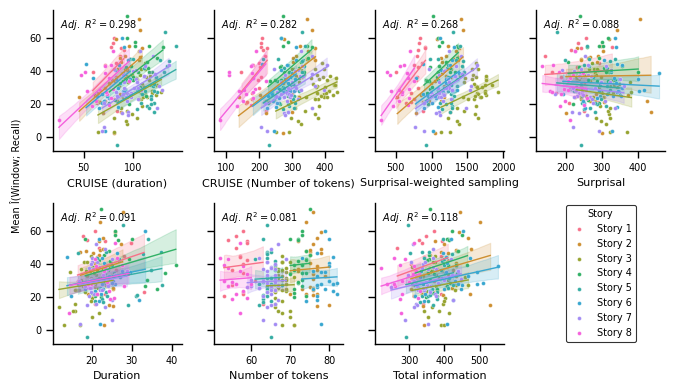

In [438]:
# sometimes this will plot without the y axis ticks. The trick is to comment out the code that gets rid of the y axis, plot once, then plot with the full code 
fig,axes = plt.subplots(2,4,figsize = (7,4),sharey=True)

plotting_preds = ['weighted_event_info_by_duration','weighted_event_info','weighted_event_info_conditioned','H_event_conditioned','event_duration','event_len','H_event']
plotting_title = ['CRUISE (duration)','CRUISE (Number of tokens)','Surprisal-weighted sampling','Surprisal','Duration','Number of tokens','Total information']
#plotting_xlabel = ['Constant-rate incremental uniform sampling \n(duration)','Constant-rate incremental uniform sampling \n(# tokens)','Incremental uniform sampling']
for ax,xx,title in zip(axes.flatten(),plotting_preds,plotting_title):
    # allow different stories to have different slopes
    fit = ols('mean_ER_intersect ~ %s+%s:C(story)'%(xx,xx), data=all_uniform_encoding_df).fit() 
    adj_r2 = fit.rsquared_adj
    boot_preds = bootstrap_ci(xx)

    for i, story in enumerate(stories):
        subset = all_uniform_encoding_df[all_uniform_encoding_df['story'] == story]
        scatter = sns.scatterplot(data=subset,
                    x=xx,
                    y='mean_ER_intersect',
                    color=sns.color_palette("husl", len(stories))[i],
                    s=8,
                    label = 'Story '+str(story_to_idx_mapping[story]),
                    ax = ax,
                    legend = False,
                )

        # 95% bootstrapped CI
        ci_lower, ci_upper = np.percentile(boot_preds[story], [2.5, 97.5], axis=0)

        x_range = np.linspace(subset[xx].min(), subset[xx].max(), 100)
        pred_df = pd.DataFrame({xx:x_range,'story':story})
        y_fit = fit.predict(pred_df)

        # Plot regression line
        ax.plot(x_range, y_fit, color=sns.color_palette("husl", len(stories))[i],lw=1)

        # Plot bootstrapped confidence interval
        ax.fill_between(x_range, ci_lower, ci_upper, color=sns.color_palette("husl", len(stories))[i], alpha=0.2)
    
    ax.set_ylabel('')
    ax.set_xlabel(title,fontsize = plot_fontsize)
    #ax.set_xlabel(xlabel,fontsize = 13)
    ax.set_title('')
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)
    ax.text(0.05, 0.95, r'$Adj.\ R^2 = %.3f$'%adj_r2, ha='left', va='top', transform=ax.transAxes,fontsize =7)


#fig.supxlabel('Predicted recalled information per window under variants of incremental uniform sampling model and controls',fontsize = 7,y = 0.055)
fig.supylabel('Mean Î(Window; Recall)',fontsize = 7,y=0.55,x = 0.03)
#plt.title('Predict I(Xi;R) under uniform encoding in time hypothesis',fontsize = 14)

sns.despine()
plt.tight_layout()
last_axis = axes.flatten()[-1]
handles, labels = scatter.get_legend_handles_labels()  # Extract legend elements
last_axis.legend(handles, labels, loc='center', title = 'Story',edgecolor='black',fontsize=7,title_fontsize=7)
last_axis.axis('off')  # Turn off the axes for a cleaner legend placement


#plt.savefig(os.path.join(figure_save_dir,'uniform_encoding_all_models_controls.svg'), transparent=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

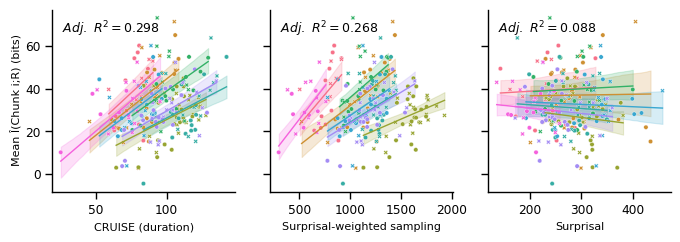

In [454]:
# need t
plotting_preds = ['weighted_event_info_by_duration','weighted_event_info_conditioned','H_event_conditioned']
plotting_title = ['CRUISE (duration)','Surprisal-weighted sampling','Surprisal']

# fig = plt.figure(figsize=(7,4))
# gs = GridSpec(1, 3, figure=fig)
# axs = [fig.add_subplot(gs[0, i], sharey=axs[0]) for i in range(3)]
fig, axs = plt.subplots(1, 3, figsize=(7,2.5),sharey = True)
for ax,xx,title in zip(axs,plotting_preds,plotting_title):
    # allow different stories to have different slopes
    fit = ols('mean_ER_intersect ~ %s+%s:C(story)'%(xx,xx), data=all_uniform_encoding_df).fit() 
    adj_r2 = fit.rsquared_adj
    boot_preds = bootstrap_ci(xx)
    
    for i, story in enumerate(stories):
        subset = all_uniform_encoding_df[all_uniform_encoding_df['story'] == story]

        # 95% bootstrapped CI
        ci_lower, ci_upper = np.percentile(boot_preds[story], [2.5, 97.5], axis=0)

        x_range = np.linspace(subset[xx].min(), subset[xx].max(), 100)
        pred_df = pd.DataFrame({xx:x_range,'story':story})
        y_fit = fit.predict(pred_df)

        # Plot regression line
        ax.plot(x_range, y_fit, color=sns.color_palette("husl", len(stories))[i],lw=1)

        # Plot bootstrapped confidence interval
        ax.fill_between(x_range, ci_lower, ci_upper, color=sns.color_palette("husl", len(stories))[i], alpha=0.2)



    # add scatter plot
    scatter = sns.scatterplot(x =xx,y = 'mean_ER_intersect',
                              data = all_uniform_encoding_df,
                              hue = 'story',
                              palette=sns.color_palette("husl", len(stories)),
                              style = 'chunk_type',
                              s = 10,
                              ax = ax,label=story)
    ax.set_ylabel('')
    ax.set_xlabel(title,fontsize = 8)
    ax.set_title('')
    ax.set_aspect(np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))
    ax.text(0.05, 0.95, r'$Adj.\ R^2 = %.3f$'%adj_r2, ha='left', va='top', transform=ax.transAxes,fontsize =9)
    scatter.legend_.remove() # remove the legend from the plot cuz we're plotting the legend separately
    

#fig.supxlabel('Predicted Î(Chunk i; R) under variants of incremental uniform sampling model and control',fontsize = 8,y = 0.055)
fig.supylabel('Mean Î(Chunk i;R) (bits)',fontsize = 8,y=0.55,x = 0.0355)
#plt.title('Predict I(Xi;R) under uniform encoding in time hypothesis',fontsize = 14)
sns.despine()
plt.tight_layout()

for ax in axs[1:]:
    ax.tick_params(axis='y', which='both', labelleft=False)  
axs[0].tick_params(axis='y', which='both', labelleft=True)

#plt.savefig(os.path.join(figure_save_dir,'uniform_encoding_boundaries_2models_control_recall_first.svg'), transparent=True)


# # plot legend separately
# fig, ax = plt.subplots(figsize=(2,4))
# ax.axis('off') 
# handles, labels = scatter.get_legend_handles_labels()

# # Number of stories for hue legend
# n_stories = len(stories)

# # Define your custom labels
# story_labels = labels[n_stories+1:2*n_stories+1]
# story_labels = ['Story '+str(story_to_idx_mapping[story]) for story in story_labels]
# chunk_labels = ['Inner', 'Boundary']

# # Define handles for each legend section
# #story_handles = handles[n_stories+1:2*n_stories+1]
# story_colors = [h.get_facecolor()[0] for h in handles[n_stories+1:2*n_stories+1]]

# # Create new handles with lines and markers
# story_handles = [
#     Line2D([0], [0], color=color, marker='o', linestyle='-', markersize=6, linewidth=1.5)
#     for color in story_colors
# ]
# chunk_handles = handles[2*(n_stories+1):]

# # Plot the story legend
# story_legend = ax.legend(story_handles, story_labels, loc="upper left", bbox_to_anchor=(0, 1), frameon=False)
# ax.add_artist(story_legend)  # Manually add the first legend to avoid overlap

# # Plot the chunk type legend below the story legend
# chunk_legend = ax.legend(chunk_handles, chunk_labels, loc="upper left", bbox_to_anchor=(0, 0.44), frameon=False)

# # Add titles using fig.text
# fig.text(0.4, 0.87, 'Story', fontsize=8, ha='center')
# fig.text(0.4, 0.44, 'Chunk Type', fontsize=8,  ha='center')

# # Display the figure
# plt.show()
# #fig.savefig(os.path.join(figure_save_dir,'uniform_encoding_boundaries_2models_control_legend.svg'), transparent = True)



In [12]:
uniform_preds = ['weighted_event_info_by_duration','weighted_event_info','weighted_event_info_conditioned']
controls = ['H_event_conditioned','H_event','event_len','event_duration']
all_preds = uniform_preds+controls
all_preds_main = ['weighted_event_info_by_duration','weighted_event_info_conditioned']+controls
uniform_preds_colors = {p:sns.color_palette("light:#005F5F_r", len(uniform_preds)+1)[i] for i,p in enumerate(uniform_preds)}
controls_colors= {p:sns.color_palette("light:#FFBF00", len(controls)+1)[i+1] for i,p in enumerate(controls)}
all_colors = {**uniform_preds_colors, **controls_colors}
all_colors.update({'chunk_type': "#ad8ec0"})

In [13]:
plotting_label_dict = {
    "weighted_event_info": "CRUISE (Number of tokens)",
    "weighted_event_info_by_duration": "CRUISE (Duration)", 
    "weighted_event_info_conditioned": "Surprisal-weighted sampling",
    'H_event_conditioned': "Surprisal",
    'H_event': "Total information",
    'event_duration': "Duration",
    "event_len": "Number of tokens",
    "chunk_type":"Event boundary"
}
plotting_label_dict_sm = {
    "weighted_event_info_by_duration": "CRUISE", 
    "weighted_event_info_conditioned": "Surprisal-weighted sampling",
    'H_event_conditioned': "Surprisal",
    'H_event': "Total information",
    'event_duration': "Duration",
    "event_len": "Number of tokens",
    "chunk_type":"Event boundary"
}
all_colors_labels = dict((plotting_label_dict[key], value) for (key, value) in all_colors.items())
all_colors_labels_sm = dict((plotting_label_dict_sm[key], value) for (key, value) in all_colors.items() if key !='weighted_event_info')

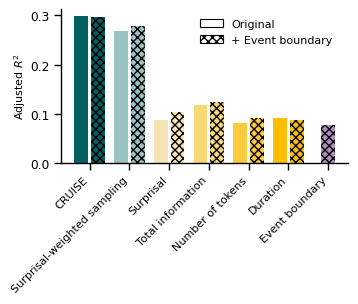

In [14]:
plot_fontsize = 8
fig,ax = plt.subplots(figsize = (3.7,2))
instruct = False
recall_first = True

if recall_first and not instruct:
    plot_target = 'mean_ER_intersect'
    recall_str = 'recall first'
    inst_str = 'direct concatenation'
elif recall_first and instruct:
    plot_target = 'mean_ER_intersect_instruct'
    recall_str = 'recall first'
    inst_str = 'instruction prompted'
elif not recall_first and not instruct:
    plot_target = 'mean_ER_intersect_recall_last'
    recall_str = 'recall last'
    inst_str = 'direct concatenation'
elif not recall_first and instruct:
    plot_target = 'mean_ER_intersect_instruct_recall_last'
    recall_str = 'recall last'
    inst_str = 'instruction prompted'
    
adj_r2_list = []
pred_list = []
model_type = []
for pred in all_preds_main:
    fit = ols('%s ~ %s+%s:C(story)'%(plot_target,pred,pred), data=all_uniform_encoding_df).fit() 
    adj_r2 = fit.rsquared_adj
    adj_r2_list.append(adj_r2)
    pred_list.append(pred)
    model_type.append('Original')
        
    fit_both = ols('%s ~ %s+%s:C(story)+C(chunk_type)+C(chunk_type):%s'%(plot_target,pred,pred,pred), data=all_uniform_encoding_df).fit() 
    adj_r2_both= fit_both.rsquared_adj
    adj_r2_list.append(adj_r2_both)
    pred_list.append(pred)
    model_type.append('+ window type intercept and interaction')
    
fit = ols('%s ~ C(chunk_type)+C(chunk_type):C(story)'%(plot_target), data=all_uniform_encoding_df).fit() 
adj_r2 = fit.rsquared_adj
adj_r2_list.append(adj_r2)
pred_list.append('chunk_type')
model_type.append('+ window type intercept and interaction')

hatch_patterns = {
    'Original': '',
    '+ intercept of window type': '/////',
    '+ window type:continuous predictor interaction': '\\\\\\\\\\',
    '+ window type intercept and interaction': 'xxxx',
}
    
pred_labels = [plotting_label_dict_sm[p] for p in pred_list]
model_adj_r2_df = pd.DataFrame({'pred':pred_list,
                                'pred_labels':pred_labels,
                               'adj_r2':adj_r2_list,
                               'model_type':model_type})
new_rows = pd.DataFrame({'pred':['chunk_type'],
                       'pred_labels':["Event boundary"],
                       'adj_r2':[np.nan],
                        'model_type':['Original']})
model_adj_r2_df = pd.concat([model_adj_r2_df, new_rows], ignore_index=True)


#sns.barplot(data=model_adj_r2_df, x="model_type", y="adj_r2", hue="pred_labels")

# Sort pred_labels to ensure consistent grouping
pred_order = model_adj_r2_df['pred_labels'].unique()
model_order = model_adj_r2_df['model_type'].unique()


# Calculate bar width and offsets
bar_width = 0.7 / len(model_order)
x_ticks = range(len(pred_order))
spacing = 0.7 / len(model_order) * 0.2     # Add small space between bars

# Plot bars
for i, model_type in enumerate(model_order):
    subset = model_adj_r2_df[model_adj_r2_df['model_type'] == model_type]
    for j, pred_label in enumerate(pred_order):
        value = subset.loc[subset['pred_labels'] == pred_label, 'adj_r2'].values
        if not np.isnan(value[0]):
            if model_type=='+ window type intercept and interaction' and pred_label =="Event boundary":
                bar = ax.bar(j + 0.5 * (bar_width + spacing), value[0], width=bar_width,
                             color=all_colors_labels_sm[pred_label], 
                             label=f"{pred_label} ({model_type})" if i == 0 else "",
                             hatch=hatch_patterns[model_type])
            else:
                bar = ax.bar(j + i * (bar_width + spacing), value[0], width=bar_width,
                             color=all_colors_labels_sm[pred_label], 
                             label=f"{pred_label} ({model_type})" if i == 0 else "",
                              hatch=hatch_patterns[model_type])

ax.set_xticks([r + (bar_width + spacing) * (len(model_order) / 2 - 0.5) for r in x_ticks])
ax.set_xticklabels(pred_order,rotation=45, ha='right',fontsize = plot_fontsize)
#ax.tick_params(axis='x', length=0) # hides ticks 
sns.despine()
ax.set_ylabel(r'Adjusted $R^2$',fontsize = plot_fontsize,labelpad=2)

# Custom legend for hatches only
from matplotlib.patches import Patch

model_type_label ={'Original':'Original',
                  '+ window type intercept and interaction':'+ Event boundary'}
# Create custom legend with hatches
legend_patches = [Patch(facecolor='white', edgecolor='black', hatch=hatch_patterns[model_type], label=model_type_label[model_type])
                  for model_type in model_order]

ax.legend(handles=legend_patches,
          bbox_to_anchor=(0.45, 1), loc='upper left',fontsize = plot_fontsize,frameon=False)

#fig.savefig(os.path.join(figure_save_dir,'uniform_encoding_r2_bar_boundary_sm_%s_%s.svg'%(recall_str,inst_str)),transparent = True)

In [15]:
def get_significance(p_val):
    if p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    else:
        return "ns"
    

                           sum_sq     df          F        PR(>F)
C(chunk_type)            8.303830    1.0  37.117207  5.137496e-09
C(story)                31.190171    7.0  19.916662  1.923178e-20
C(chunk_type):C(story)   0.835626    7.0   0.533594  8.085210e-01
Residual                47.652179  213.0        NaN           NaN


(0.0, 1.0, 0.0, 1.0)

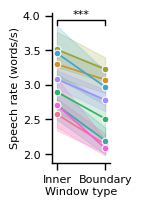

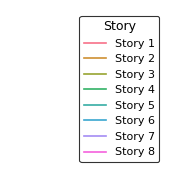

In [16]:
plot_fontsize = 8
# ANOVA
model = ols('word_rate ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)

plt.figure(figsize=(1,2))
ax=sns.lineplot(x='chunk_type', y='word_rate', 
             hue='story_idx', 
             data=all_concat_df, 
             marker='o',
             estimator='mean',
            palette = sns.color_palette("husl",len(stories)),
            #errorbar='se',
            legend = True)
ax.legend_.remove()
ax.tick_params(axis='x', labelsize=plot_fontsize)
ax.tick_params(axis='y', labelsize=plot_fontsize)
plt.xlabel('Window type',fontsize = plot_fontsize,labelpad=2)
plt.ylabel('Speech rate (words/s)',fontsize = plot_fontsize,labelpad=2)
ax.set_xlim([-0.1,1.1])

x1, x2 = 0, 1  # Positions of the two categories in 'chunk_type'
ymin, ymax = plt.gca().get_ylim()
# Set the height of the bracket as a fraction of the y-axis range
h = (ymax - ymin) * 0.04 
y = ymax - h  # Position the bracket close to the top
col = 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
sig_text = get_significance(chunk_type_pval)
plt.text((x1+x2)*.5, y+h, sig_text, ha='center', va='bottom', color=col, fontsize=plot_fontsize)
sns.despine()
plt.subplots_adjust(left=0.20, right=0.78, bottom=0.2, top=0.95)
plt.savefig(os.path.join(figure_save_dir,'word_rate.svg'),transparent = True)



# Extract the legend
handles, labels = ax.get_legend_handles_labels()
# Plot the legend separately
fig1, ax1 = plt.subplots(figsize =(2,2))
plt.legend(handles, labels,fontsize = plot_fontsize,edgecolor='black',title = 'Story',title_fontsize = plot_fontsize+1)
ax1.axis('off')
#fig1.savefig(os.path.join(figure_save_dir,'story_idx_legend.svg'),transparent = True)


                             sum_sq     df          F        PR(>F)
C(chunk_type)            125.591083    1.0  18.318036  2.825313e-05
C(story)                 927.898954    7.0  19.334046  6.357173e-20
C(chunk_type):C(story)    22.462670    7.0   0.468040  8.570106e-01
Residual                1460.358596  213.0        NaN           NaN


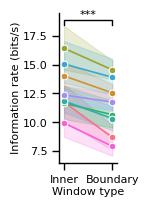

In [414]:
model = ols('conditioned_info_per_sec ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)


plt.figure(figsize=(1,2))
ax=sns.lineplot(x='chunk_type', y='conditioned_info_per_sec', 
             hue='story', 
             data=all_concat_df, 
             marker='o',
             estimator='mean',
            palette = sns.color_palette("husl",len(stories)),
            #errorbar='se',
            legend = False)
ax.set_xlim([-0.1,1.1])

x1, x2 = 0, 1  # Positions of the two categories in 'chunk_type'
ymin, ymax = plt.gca().get_ylim()
# Set the height of the bracket as a fraction of the y-axis range
h = (ymax - ymin) * 0.04
y = ymax - h  # Position the bracket close to the top
col = 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
sig_text = get_significance(chunk_type_pval)
plt.text((x1+x2)*.5, y+h, sig_text, ha='center', va='bottom', color=col, fontsize=plot_fontsize)
sns.despine()
plt.subplots_adjust(left=0.20, right=0.78, bottom=0.2, top=0.95)

ax.tick_params(axis='x', labelsize=plot_fontsize)
ax.tick_params(axis='y', labelsize=plot_fontsize)
plt.xlabel('Window type',fontsize = plot_fontsize,labelpad=2)
plt.ylabel('Information rate (bits/s)',fontsize = plot_fontsize,labelpad=2)
plt.savefig(os.path.join(figure_save_dir,'conditional_info_rate.svg'),transparent = True)

                               sum_sq     df          F        PR(>F)
C(chunk_type)             3013.897340    1.0   1.433132  2.325846e-01
C(story)                253692.009977    7.0  17.233226  5.274712e-18
C(chunk_type):C(story)   12837.973440    7.0   0.872080  5.294027e-01
Residual                447941.976669  213.0        NaN           NaN


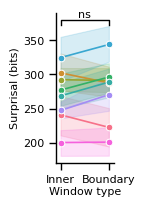

In [367]:
model = ols('H_event_conditioned ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)


plt.figure(figsize=(1,2))
ax=sns.lineplot(x='chunk_type', y='H_event_conditioned', 
             hue='story', 
             data=all_concat_df, 
             marker='o',
             estimator='mean',
            palette = sns.color_palette("husl",len(stories)),
            #errorbar='se',
            legend = False)

ax.set_xlim([-0.1,1.1])
x1, x2 = 0, 1  # Positions of the two categories in 'chunk_type'
ymin, ymax = plt.gca().get_ylim()
# Set the height of the bracket as a fraction of the y-axis range
h = (ymax - ymin) * 0.04
y = ymax - h  # Position the bracket close to the top
col = 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
sig_text = get_significance(chunk_type_pval)
plt.text((x1+x2)*.5, y+h, sig_text, ha='center', va='bottom', color=col, fontsize=plot_fontsize)
sns.despine()
plt.subplots_adjust(left=0.20, right=0.78, bottom=0.2, top=0.95)

ax.tick_params(axis='x', labelsize=plot_fontsize)
ax.tick_params(axis='y', labelsize=plot_fontsize)
plt.xlabel('Window type',fontsize = plot_fontsize,labelpad=2)
plt.ylabel('Surprisal (bits)',fontsize = plot_fontsize,labelpad=2)
plt.savefig(os.path.join(figure_save_dir,'conditional_info.svg'),transparent = True)

In [325]:
model = ols('event_len ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)

                              sum_sq     df           F         PR(>F)
C(chunk_type)               0.182894    1.0    0.046288   8.298589e-01
C(story)                10477.774767    7.0  378.827102  1.876941e-116
C(chunk_type):C(story)     11.136582    7.0    0.402646   9.000307e-01
Residual                  841.607468  213.0         NaN            NaN


                             sum_sq     df          F        PR(>F)
C(chunk_type)            588.448726    1.0  42.152505  5.845232e-10
C(story)                1250.025623    7.0  12.791917  1.084588e-13
C(chunk_type):C(story)   114.691554    7.0   1.173676  3.191050e-01
Residual                2973.478779  213.0        NaN           NaN


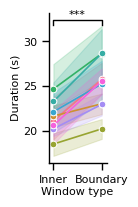

In [368]:
model = ols('Duration ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)


plt.figure(figsize=(1,2))
ax=sns.lineplot(x='chunk_type', y='Duration', 
             hue='story', 
             data=all_concat_df, 
             marker='o',
             estimator='mean',
            palette = sns.color_palette("husl",len(stories)),
            #errorbar='se',
            legend = False)

ax.set_xlim([-0.1,1.1])
x1, x2 = 0, 1  # Positions of the two categories in 'chunk_type'
ymin, ymax = plt.gca().get_ylim()
# Set the height of the bracket as a fraction of the y-axis range
h = (ymax - ymin) * 0.04
y = ymax - h  # Position the bracket close to the top
col = 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
sig_text = get_significance(chunk_type_pval)
plt.text((x1+x2)*.5, y+h, sig_text, ha='center', va='bottom', color=col, fontsize=plot_fontsize)
sns.despine()
plt.subplots_adjust(left=0.20, right=0.78, bottom=0.2, top=0.95)

ax.tick_params(axis='x', labelsize=plot_fontsize)
ax.tick_params(axis='y', labelsize=plot_fontsize)
plt.xlabel('Window type',fontsize = plot_fontsize,labelpad=2)
plt.ylabel('Duration (s)',fontsize = plot_fontsize,labelpad=2)
plt.savefig(os.path.join(figure_save_dir,'duration.svg'),transparent = True)

In [338]:
all_concat_df.groupby('chunk_type').mean()['Duration']

/tmp/ipykernel_3513782/1639472849.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_concat_df.groupby('chunk_type').mean()['Duration']


chunk_type
Boundary    24.507811
Inner       21.369332
Name: Duration, dtype: float64

                              sum_sq     df         F    PR(>F)
C(chunk_type)             677.006976    1.0  4.155223  0.042742
C(story)                 4630.723588    7.0  4.060243  0.000335
C(chunk_type):C(story)    379.636986    7.0  0.332868  0.938344
Residual                34703.907594  213.0       NaN       NaN


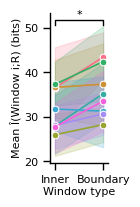

In [369]:
model = ols('mean_ER_intersect ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)


plt.figure(figsize=(1,2))
ax=sns.lineplot(x='chunk_type', y='mean_ER_intersect', 
             hue='story', 
             data=all_concat_df, 
             marker='o',
             estimator='mean',
            palette = sns.color_palette("husl",len(stories)),
            #errorbar='se',
            legend = False)

ax.set_xlim([-0.1,1.1])
x1, x2 = 0, 1  # Positions of the two categories in 'chunk_type'
ymin, ymax = plt.gca().get_ylim()
# Set the height of the bracket as a fraction of the y-axis range
h = (ymax - ymin) * 0.04
y = ymax - h  # Position the bracket close to the top
col = 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
sig_text = get_significance(chunk_type_pval)
plt.text((x1+x2)*.5, y+h, sig_text, ha='center', va='bottom', color=col, fontsize=plot_fontsize)
sns.despine()
plt.subplots_adjust(left=0.20, right=0.78, bottom=0.2, top=0.95)

ax.tick_params(axis='x', labelsize=plot_fontsize)
ax.tick_params(axis='y', labelsize=plot_fontsize)
plt.xlabel('Window type',fontsize = plot_fontsize,labelpad=2)
plt.ylabel('Mean Î(Window i;R) (bits)',fontsize = plot_fontsize,labelpad=2)
plt.savefig(os.path.join(figure_save_dir,'mean_recalled_info_recall_first.svg'),transparent = True)

In [324]:
all_concat_df.groupby('chunk_type')['mean_ER_intersect'].mean()

chunk_type
Boundary    34.259854
Inner       31.137214
Name: mean_ER_intersect, dtype: float64

                              sum_sq     df          F        PR(>F)
C(chunk_type)            1097.546762    1.0   5.993016  1.517161e-02
C(story)                46855.534104    7.0  36.549821  2.646742e-33
C(chunk_type):C(story)   1852.833142    7.0   1.445309  1.886078e-01
Residual                39008.315586  213.0        NaN           NaN


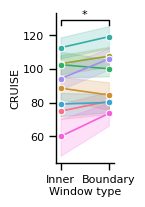

In [450]:
model = ols('weighted_event_info_by_duration ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)


plt.figure(figsize=(1,2))
ax=sns.lineplot(x='chunk_type', y='weighted_event_info_by_duration', 
             hue='story', 
             data=all_concat_df, 
             marker='o',
             estimator='mean',
            palette = sns.color_palette("husl",len(stories)),
            #errorbar='se',
            legend = False)

ax.set_xlim([-0.1,1.1])
x1, x2 = 0, 1  # Positions of the two categories in 'chunk_type'
ymin, ymax = plt.gca().get_ylim()
# Set the height of the bracket as a fraction of the y-axis range
h = (ymax - ymin) * 0.04
y = ymax - h  # Position the bracket close to the top
col = 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
sig_text = get_significance(chunk_type_pval)
plt.text((x1+x2)*.5, y+h, sig_text, ha='center', va='bottom', color=col, fontsize=plot_fontsize)
sns.despine()
plt.subplots_adjust(left=0.20, right=0.78, bottom=0.2, top=0.95)

ax.tick_params(axis='x', labelsize=plot_fontsize)
ax.tick_params(axis='y', labelsize=plot_fontsize)
plt.xlabel('Window type',fontsize = plot_fontsize,labelpad=2)
plt.ylabel('CRUISE',fontsize = plot_fontsize,labelpad=2)
plt.savefig(os.path.join(figure_save_dir,'uniform_encoding_duration_boundary_inner.svg'),transparent = True)

In [456]:
model = ols('weighted_event_info_conditioned ~ C(chunk_type) + C(story) + C(chunk_type):C(story)', data=all_concat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 
chunk_type_pval = anova_table['PR(>F)']['C(chunk_type)']
print(anova_table)

                              sum_sq     df          F        PR(>F)
C(chunk_type)           2.189641e+04    1.0   0.799697  3.721932e-01
C(story)                1.623189e+07    7.0  84.688388  4.931356e-58
C(chunk_type):C(story)  2.766874e+05    7.0   1.443591  1.892670e-01
Residual                5.832125e+06  213.0        NaN           NaN


In [459]:
# constant rate, weighted by duration 
# chunk type slope only: p = 0.295
# chunk type intercept only: p=0.25
# original model (no chunk type terms) Adj.R^2: 0.298
fit = ols('mean_ER_intersect ~ C(chunk_type):weighted_event_info_by_duration+C(chunk_type)+weighted_event_info_by_duration+C(story):weighted_event_info_by_duration', data=all_concat_df).fit() 

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:      mean_ER_intersect   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     10.61
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           1.34e-14
Time:                        11:13:47   Log-Likelihood:                -871.45
No. Observations:                 229   AIC:                             1765.
Df Residuals:                     218   BIC:                             1803.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [462]:
# constant rate, weighted by tokens: 
# chunk type slope alone p = 0.078
# chunk type intercept alone p = 0.037
# original model (no chunk type terms) Adj.R^2: 0.282
fit = ols('mean_ER_intersect ~ C(chunk_type)+C(chunk_type):weighted_event_info+weighted_event_info+C(story):weighted_event_info', data=all_concat_df).fit() 

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:      mean_ER_intersect   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     10.47
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           2.08e-14
Time:                        11:14:17   Log-Likelihood:                -871.94
No. Observations:                 229   AIC:                             1766.
Df Residuals:                     218   BIC:                             1804.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [467]:
# conditioned information 
# chunk type slope only:0.113
# chunk type intercept only: p=0.051
# original model (no chunk type terms) Adj.R^2: 0.268
fit = ols('mean_ER_intersect ~ C(chunk_type)+C(chunk_type):weighted_event_info_conditioned+weighted_event_info_conditioned+C(story):weighted_event_info_conditioned', data=all_concat_df).fit() 

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:      mean_ER_intersect   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     9.795
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           1.75e-13
Time:                        11:17:44   Log-Likelihood:                -874.37
No. Observations:                 229   AIC:                             1771.
Df Residuals:                     218   BIC:                             1809.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------